<a href="https://colab.research.google.com/github/Zak1105/Trimble-test/blob/main/test_technical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The first part


In [ ]:
!unzip /content/dataset.zip

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm
import time
import torch.nn.functional as F
# Define a transformation to resize images to 224x224 and perform data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the data from the dataset folder
dataset = ImageFolder("dataset", transform=transform)

# Split the data into training, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.2 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for the training, validation, and test sets
batch_size=16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=4)


# Define the model ResNet101 with an output  classification

class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision', 'resnet101', pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, 1)  # Output layer with one outputs for binary classification
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        return self.sigmoid(self.resnet(x))



# Instantiate the model
model = ResNetModel()

# Define Loss
device ="cuda"# torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.L1Loss ().to(device)
# Define the optimizer adn the scheduler
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.9,verbose=True)
# Training the model

model.to(device)

epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
start_time=time.time()
print ("---------------------------------- Start of training ----------------------------------")
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0

    for inputs, labels in tqdm(train_loader):
        labels=labels.to(device)

        inputs, labels = inputs.to(device), labels.unsqueeze(1).float()
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        outputs[outputs>0.5]=1
        outputs[outputs<0.5]=0

        running_loss += loss.item()

        correct_train += (outputs == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / len(train_dataset)
    scheduler.step()
    # Validation
    model.eval()
    running_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            labels=labels.to(device)
            inputs, labels = inputs.to(device), labels.unsqueeze(1).float()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()
            outputs[outputs>0.5]=1
            outputs[outputs<0.5]=0

            correct_val += (outputs == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct_val / len(val_dataset)

    print(f"Epoch {epoch + 1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
print("---------------------------------- End of trainning ----------------------------------")
end_time = time.time()

# Calculate the total training time in seconds
training_time_seconds = end_time - start_time


# Calculate the total training time in seconds
training_time_minutes = training_time_seconds // 60
remaining_seconds = training_time_seconds % 60

print(f"Total training time: {training_time_minutes:.0f} minutes and {remaining_seconds:.2f} seconds")

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train')
plt.plot(range(1, epochs + 1), val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.show()


In [ ]:
!unzip /content/test.zip

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = torch.load('/content/model_final.pth')
model1.eval()
test_dataset = ImageFolder("test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

# Create prediction folders
if not os.path.exists("predicted_0"):
    os.makedirs("predicted_0")
if not os.path.exists("predicted_1"):
    os.makedirs("predicted_1")

with torch.no_grad():
    for idx, (inputs, _) in enumerate(test_loader):
        inputs =  inputs.to(device)
        outputs = model(inputs)
        predicted = 0 if outputs.item() < 0.5 else 1
        print(f"Image {idx}: Predicted {'road' if predicted == 1 else 'field'}")

        original_image = inputs.permute(0, 2, 3, 1).cpu().numpy().squeeze()

        # Save the image with appropriate naming
        prediction_folder = "predicted_1" if predicted == 1 else "predicted_0"
        image_name = f"image_{idx}_predicted_{predicted}.png"
        image_path = os.path.join(prediction_folder, image_name)

        plt.imshow(original_image, cmap='gray')
        plt.title(f"Predicted: {'road' if predicted == 1 else 'field'}")
        plt.savefig(image_path)
        plt.clf()  # Clear the plot for the next iteration






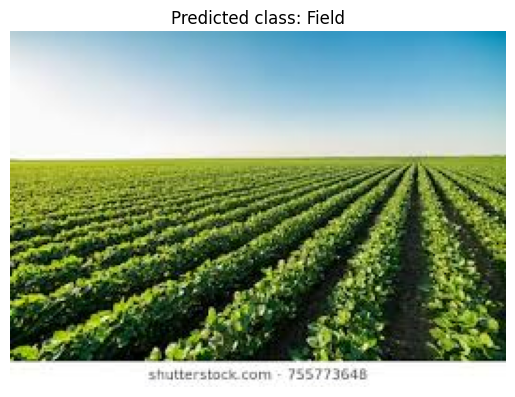

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision', 'resnet101', pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, 1)  # Output layer with one outputs
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        return self.sigmoid(self.resnet(x))


def predict_image_class(model_path, image_path):
    # Define the transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(5),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load the model
    model = torch.load(model_path, map_location=torch.device('cpu')) # Load the model from model.pth
    model.eval()  # Set the model to evaluation mode

    # Load and preprocess the image
    image = Image.open(image_path)
    original_image = image.copy()  # Make a copy for display
    image = transform(image)  # Apply the defined transformations

    # Make a prediction
    with torch.no_grad():
        output = model(image.unsqueeze(0))  # Add batch dimension to the image
        prediction = torch.round(output).item()  # Round the output to get the prediction (0 or 1)

    # Map the prediction to class labels
    class_labels = ['Field', 'Road']
    predicted_class = class_labels[int(prediction)]

    # Display the image with the predicted class as the title
    plt.imshow(original_image)
    plt.title(f"Predicted class: {predicted_class}")
    plt.axis('off')  # Turn off axis
    plt.show()

# Usage example
if __name__ == "__main__":
    model_path = '/content/model_final.pth'  # Replace with the actual path to your trained model file
    image_path = '/content/35.jpg'  # Replace with the path to the image you want to predict
    predict_image_class(model_path, image_path)



# The second part

In [ ]:
!unzip /content/data.zip

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


Adjusting learning rate of group 0 to 1.0000e-05.
---------------------------------- Start of fine-tuning ----------------------------------


100%|██████████| 7/7 [00:02<00:00,  2.43it/s]

Adjusting learning rate of group 0 to 9.0000e-06.


Epoch 1/7, Train Loss: 0.4459, Validation Loss: 0.4127, Train Accuracy: 79.82%, Validation Accuracy: 86.36%


100%|██████████| 7/7 [00:02<00:00,  2.52it/s]

Adjusting learning rate of group 0 to 8.1000e-06.


Epoch 2/7, Train Loss: 0.3348, Validation Loss: 0.3339, Train Accuracy: 78.90%, Validation Accuracy: 59.09%


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]

Adjusting learning rate of group 0 to 7.2900e-06.


Epoch 3/7, Train Loss: 0.1986, Validation Loss: 0.1877, Train Accuracy: 78.90%, Validation Accuracy: 90.91%


100%|██████████| 7/7 [00:02<00:00,  2.50it/s]

Adjusting learning rate of group 0 to 6.5610e-06.


Epoch 4/7, Train Loss: 0.0889, Validation Loss: 0.0695, Train Accuracy: 97.25%, Validation Accuracy: 100.00%


100%|██████████| 7/7 [00:04<00:00,  1.74it/s]

Adjusting learning rate of group 0 to 5.9049e-06.


Epoch 5/7, Train Loss: 0.0199, Validation Loss: 0.0138, Train Accuracy: 100.00%, Validation Accuracy: 100.00%


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]

Adjusting learning rate of group 0 to 5.3144e-06.


Epoch 6/7, Train Loss: 0.0026, Validation Loss: 0.0056, Train Accuracy: 100.00%, Validation Accuracy: 100.00%


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

Adjusting learning rate of group 0 to 4.7830e-06.


Epoch 7/7, Train Loss: 0.0006, Validation Loss: 0.0038, Train Accuracy: 100.00%, Validation Accuracy: 100.00%
---------------------------------- End of fine-tuning ----------------------------------


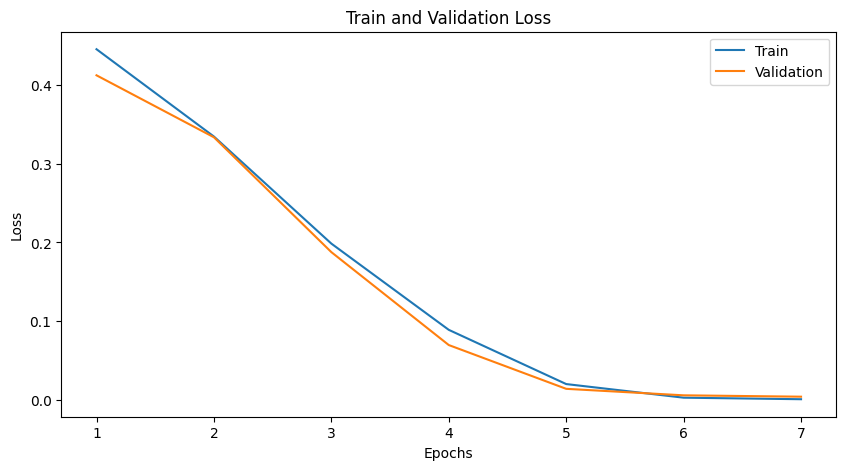

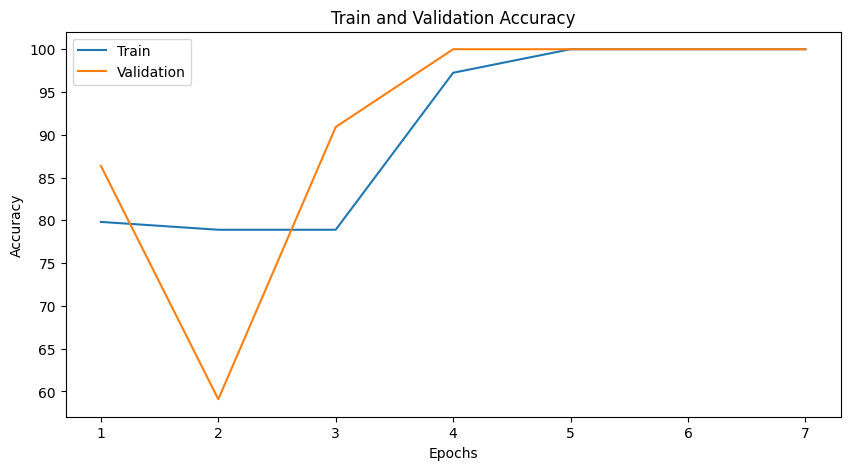

In [ ]:

model_path = '/content/model_final.pth'
# Load the state dictionary of the pre-trained model
pretrained_state_dict = torch.load(model_path, map_location=torch.device('cpu'))

# Instantiate your model
model = ResNetModel()

# Get the state dictionary of your model
model_state_dict = model.state_dict()


# Load the updated state dictionary
model.load_state_dict(model_state_dict)

#
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()  # Set the model to training mode

# Load the dataset from "data"
new_dataset = ImageFolder("data", transform=transform)


# Split the dataset into train, validation, and test sets
test_size = int(0.15 * len(dataset))
train_size = len(dataset) - 2 * test_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, test_size, test_size])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
# Définir le critère de perte (vous pouvez ajuster si nécessaire)
criterion = nn.L1Loss().to(device)


optimizer = optim.Adam(model.parameters(), lr=0.00001,weight_decay=0.002)
scheduler = ExponentialLR(optimizer, gamma=0.9, verbose=True)

epochs = 7
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("---------------------------------- Start of fine-tuning ----------------------------------")
for epoch in range(epochs):
    running_train_loss = 0.0
    correct_train = 0

    for inputs, labels in tqdm(train_loader):
        labels = labels.to(device)
        inputs, labels = inputs.to(device), labels.unsqueeze(1).float()
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        outputs[outputs > 0.5] = 1
        outputs[outputs < 0.5] = 0

        running_train_loss += loss.item()
        correct_train += (outputs == labels).sum().item()

    train_loss = running_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / len(train_dataset)
    scheduler.step()

    # Validation
    running_val_loss = 0.0
    correct_val = 0

    model.eval()  # Mettre le modèle en mode évaluation
    with torch.no_grad():
        for inputs, labels in val_loader:
            labels = labels.to(device)
            inputs, labels = inputs.to(device), labels.unsqueeze(1).float()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            outputs[outputs > 0.5] = 1
            outputs[outputs < 0.5] = 0

            correct_val += (outputs == labels).sum().item()

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / len(val_dataset)

    print(f"Epoch {epoch + 1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

print("---------------------------------- End of fine-tuning ----------------------------------")


plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train')
plt.plot(range(1, epochs + 1), val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.show()


In [ ]:
# Test the model on the test set
model.eval()
test_loss = 0.0
correct_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        labels = labels.to(device)
        inputs, labels = inputs.to(device), labels.unsqueeze(1).float()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        test_loss += loss.item()

        outputs[outputs > 0.5] = 1
        outputs[outputs < 0.5] = 0

        correct_test += (outputs == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / len(test_dataset)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.0070, Test Accuracy: 100.00%


In [ ]:
new_model_path = '/content/model_dataset_datafinal.pth'
checkpoint = {'model_state_dict': model.state_dict()}
torch.save(checkpoint, new_model_path)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


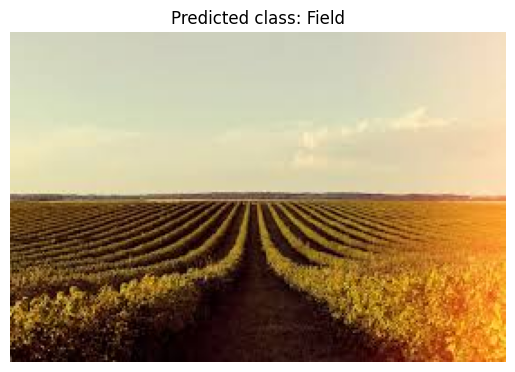

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


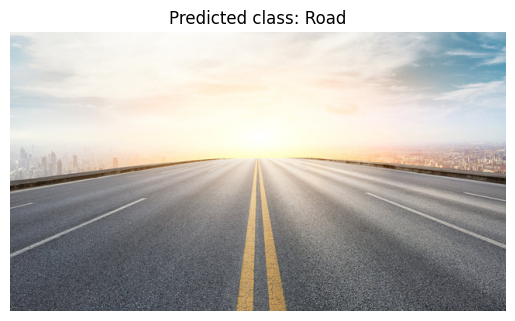

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision', 'resnet101', pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, 1)  # Output layer with one outputs
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        return self.sigmoid(self.resnet(x))


def predict_image_class1(model_path, image_path):
    # Define the transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Recreate the model and load the state from the saved checkpointx
    model = ResNetModel()
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set the model to evaluation mode

    # Load and preprocess the image
    image = Image.open(image_path)
    original_image = image.copy()  # Make a copy for display
    image = transform(image)  # Apply the defined transformations

    # Make a prediction
    with torch.no_grad():
        output = model(image.unsqueeze(0))  # Add batch dimension to the image
        prediction = torch.round(output).item()  # Round the output to get the prediction (0 or 1)

    # Map the prediction to class labels
    class_labels = ['Field', 'Road']
    predicted_class = class_labels[int(prediction)]

    # Display the image with the predicted class as the title
    plt.imshow(original_image)
    plt.title(f"Predicted class: {predicted_class}")
    plt.axis('off')  # Turn off axis
    plt.show()

# Usage example
if __name__ == "__main__":
    model_path = '/content/model_dataset_datafinal.pth'  # Replace with the actual path to your trained model file
    image_path = '/content/feildsdq.jpg'  # Replace with the path to the image you want to predict
    image ='/content/3.jpg'
    predict_image_class1(model_path, image_path)
    predict_image_class1(model_path, image)

